In [33]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import os
os.makedirs("../out", exist_ok=True)

from tqdm import tqdm

# Q2: Affine Motion Subtraction

Make sure to comment your code and use proper names for your variables.

## Q2.1: Lucas-Kanade Tracking with Affine Motion

In [34]:
# We recommend using this function, but you can explore other methods as well (e.g., ndimage.shift).
from scipy.interpolate import RectBivariateSpline

# The function below could be useful as well :) 
# from numpy.linalg import lstsq

def LucasKanadeAffine(It, It1, threshold, num_iters):
    """
    :param[np.array(H, W)] It   : Image frame at time-step t
    :param[np.array(H, W)] It1  : Image frame at time-step t+1
    :param[float] threshold     : If the length of dp < threshold, terminate the optimization
    :param[int] num_iters       : Number of iterations for running the optimization

    :return[np.array(2, 3)] M   : Affine warp matrix
    """
    # Initial M
    M = np.eye(3)
#     M = np.array([[1.0, 0.0, 0.0], [0.0, 1.0, 0.0]])
    
    # ----------------------------------------------------------------------------------------------
    # TODO: Add your LK implementation here: 
    
    # Initial guess of p:
    p0 = np.zeros(6)
    p = p0
    
    # shift for It and It1 to get It_rec, It1_rec for future .ev()
    h_t,w_t = np.shape(It)
    y_wrap, x_wrap = np.meshgrid(np.linspace(0, h_t, h_t, endpoint = False), np.linspace(0, w_t, w_t, endpoint = False))
    It_rec = RectBivariateSpline(y_wrap[0,:], x_wrap[:, 0], It)
    
    width = w_t
    height = h_t
    
    h_1, w_1 = np.shape(It1)
    y1_wrap, x1_wrap = np.meshgrid(np.linspace(0, h_1, h_1, endpoint = False), np.linspace(0, w_1, w_1, endpoint = False))
    It1_rec = RectBivariateSpline(y1_wrap[0,:], x1_wrap[:, 0], It1)
    
    # Get the index of the template pixel
    y_pos, x_pos = np.meshgrid(np.linspace(0, h_t, h_t, endpoint = False),np.linspace(0, w_t, w_t, endpoint = False))
   
    # Create x in homogeneous coordinate: 3x3
    x_pos = np.reshape(x_pos,(1,width * height))
    y_pos = np.reshape(y_pos,(1,height * width))
    X_h = np.vstack((x_pos, y_pos, np.ones((1,height * width))))

    
    for i in range(0, num_iters):
        # Affine wrap in homogeneous coordinate
        M = np.array([[1+p[0], p[2], p[4]],
                      [p[1], 1+p[3], p[5]],
                      [0, 0, 1]])
        
        #x'= Mx
        X_prime = M @ X_h
        
        # ---------------------------------------------------------
        # Select pixels lying in the common region of It and It+1
        xp = X_prime[0]
        yp = X_prime[1]
        
        #Selecting only valid xp and yp
        idx = np.logical_and.reduce((xp >= 0, xp < w_t, yp >= 0, yp < h_t))
        
        # Update pixels to be only valid one
        x_new = x_pos[:,idx]
        y_new = y_pos[:,idx]
        
        xp_new = xp[idx]
        yp_new = yp[idx]
        # ---------------------------------------------------------
        gIx = It1_rec.ev(yp_new, xp_new, dy=1).flatten()
        gIy = It1_rec.ev(yp_new, xp_new, dx=1).flatten()
        
        Template = It_rec.ev(y_new, x_new).flatten()
        It1_wrap = It1_rec.ev(yp_new, xp_new).flatten()
        
        # Reshape the matrix to be (N,1)
        x_new = np.reshape(x_new,(x_new.shape[1],1))
        y_new = np.reshape(y_new,(y_new.shape[1],1))
        
        xp_new = np.reshape(xp_new,(len(xp_new),1))
        yp_new = np.reshape(yp_new,(len(yp_new),1))
        
        gIx = np.reshape(gIx, (len(gIx), 1))
        gIy = np.reshape(gIy, (len(gIy), 1))
        
        # Build linear system A,b:
        A1 = np.multiply(gIx, x_new)
        A2 = np.multiply(gIy, x_new)
        A3 = np.multiply(gIx, y_new)
        A4 = np.multiply(gIy, y_new)

        A = np.hstack((A1,A2,A3,A4,gIx,gIy))
        
        b = np.reshape(Template - It1_wrap, (len(xp_new), 1))
        
        delta_p = np.linalg.pinv(A).dot(b) #(6,1)

        dp = np.linalg.norm(delta_p)
        
        if(dp < threshold):
            break
        
        p = (p + delta_p.T).flatten()
#         print(p)
    
    # ----------------------------------------------------------------------------------------------
    return M

# Q2.2: Dominant Motion Subtraction

In [35]:
# These functions could be useful for your implementation. 
from scipy.ndimage import binary_erosion, binary_dilation, affine_transform
# import cv2

def SubtractDominantMotion(It, It1, num_iters, threshold, tolerance):
    """
    :param[np.array(H, W)] It   : Image frame at time-step t
    :param[np.array(H, W)] It1  : Image frame at time-step t+1
    :param[float] threshold     : For LucasKanadeAffine --> If the length of dp < threshold, 
                                  terminate the optimization
    :param[int] num_iters       : For LucasKanadeAffine --> Number of iterations for running the 
                                  optimization
    :param[float] tolerance     : Binary threshold of intensity difference when computing the mask.
   
    :return[np.array(H, W)] mask: Binary mask indicating moving pixels. 
    """
    mask = np.ones(It1.shape, dtype=bool)

    # ----------------------------------------------------------------------------------------------
    # TODO: Add your code here:
    M = LucasKanadeAffine(It, It1, threshold, num_iters)
    M_inv = np.linalg.inv(M)
    
    # Wrap the image It using M so that it's registered to It+1
    It_wrap = affine_transform(It, M[0:2,0:2], offset = M[0:2,2], output_shape = It1.shape)
    
    # Substract the wraped image from It+1
    Diff = abs(It1 - It_wrap)
    
    # where absolute diff exceeds a torance can be declared as corresponding to thelocations of moving objects
    mask[Diff <= tolerance] = 0
    
    # Better results for using erosion and dilation
    mask = binary_erosion(mask,structure = np.eye(2))
    mask = binary_dilation(mask,iterations = 2)
    # ----------------------------------------------------------------------------------------------
    return mask 

## Q2.3: Track Sequence

In [36]:
def TrackSequenceAffineMotion(seq, num_iters, threshold, tolerance):
    """
    :param[np.array(H, W, N)] seq : sequence of frames
    :param[int] num_iters         : Number of iterations for running the optimization
    :param[float] threshold       : If the length of dp < threshold, terminate the optimization
    :param[float] tolerance       : Binary threshold of intensity difference when computing the mask.

    :return[np.array(H, W)] mask: Binary mask indicating moving pixels.
    """
    H, W, N = seq.shape

    masks = []
#     It = seq[:,:,0]

    # ----------------------------------------------------------------------------------------------
    # TODO: Add your code here:
    for i in tqdm(range(N-1)):
        It = seq[:, :, i]
        It1 = seq[:, :, i+1]
        mask = SubtractDominantMotion(It, It1, num_iters, threshold, tolerance)
        masks.append(mask)

    # ----------------------------------------------------------------------------------------------
#     masks = np.stack(masks, axis=2)
    return masks

### Q2.3: Track Ant Sequence

Feel free to play with these snippets of code; run ablations, visualize a gif with the whole sequence, etc.

Just make sure the bounding boxes for the car are clearly visible, and report those of the frames we requested. 

In [39]:
# your code goes here
seq = np.load("../data/antseq.npy")

# NOTE: feel free to play with these parameters
num_iters = 100
threshold = 1e-2
tolerance = 0.04

masks = TrackSequenceAffineMotion(seq, num_iters, threshold, tolerance)
np.save(f'../out/antseqmasks.npy', masks)

100%|█████████████████████████████████████████| 124/124 [00:46<00:00,  2.69it/s]


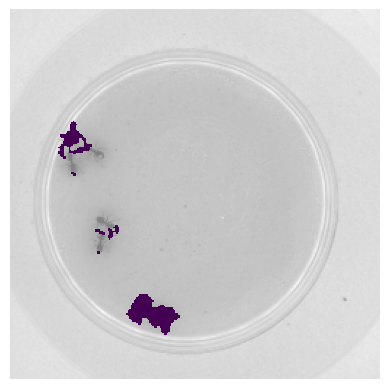

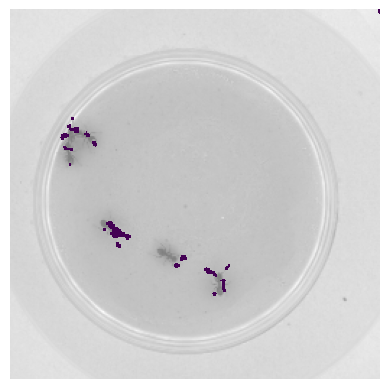

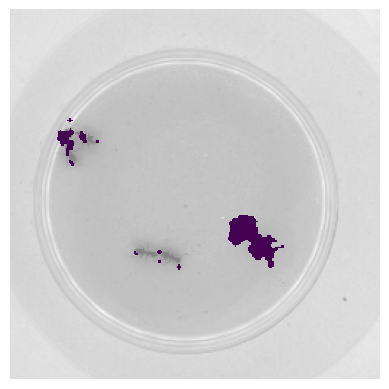

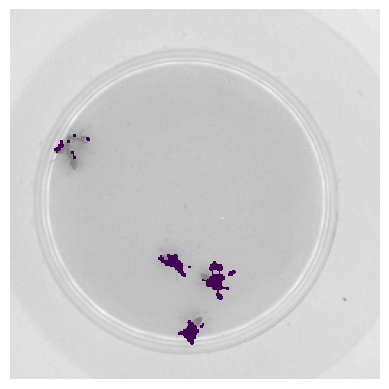

In [40]:
# TODO: visualize
frames_to_save = [30, 60, 90, 120]

for idx in frames_to_save:
    frame = seq[:,:,idx]
    mask = masks[idx-1]
    plt.figure()
    plt.imshow(frame, cmap="gray", alpha=0.5)
    plt.imshow(np.ma.masked_where(np.invert(mask), mask))
    plt.axis('off')
    plt.savefig(f"../out/sol_2.3_antseq_{idx}.png")
    
    # frame = 
    # mask = 
   
    # plt.figure()
    # plt.imshow(frame, cmap="gray", alpha=0.5)
    # plt.imshow(np.ma.masked_where(np.invert(mask), mask))
    # plt.axis('off')
    # plt.savefig(f"../out/sol_2.3_antseq_{idx+1}.png")

### Q2.3: Test Aerial Sequence

Feel free to play with these snippets of code; run ablations, visualize a gif with the whole sequence, etc.

Just make sure the bounding boxes for the car are clearly visible, and report those of the frames we requested. 

In [42]:
seq = np.load("../data/aerialseq.npy")

# NOTE: feel free to play with these parameters
num_iters = int(1e4)
threshold = 1e-2
tolerance = 0.18

masks = TrackSequenceAffineMotion(seq, num_iters, threshold, tolerance)
np.save(f'../out/aerialseqmasks.npy', masks)

100%|█████████████████████████████████████████| 149/149 [02:04<00:00,  1.20it/s]


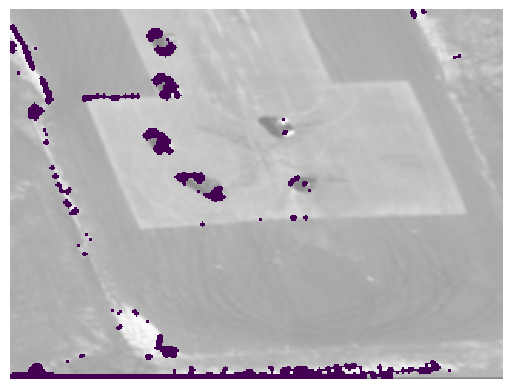

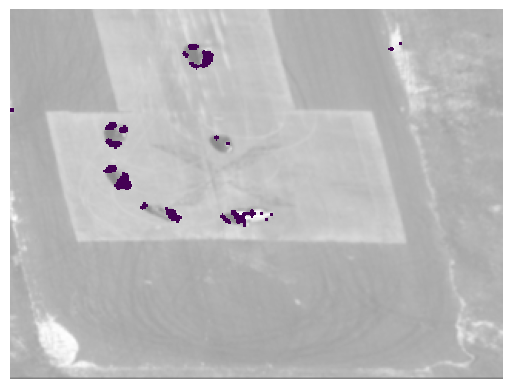

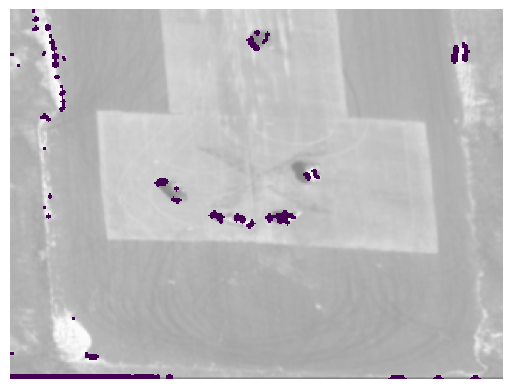

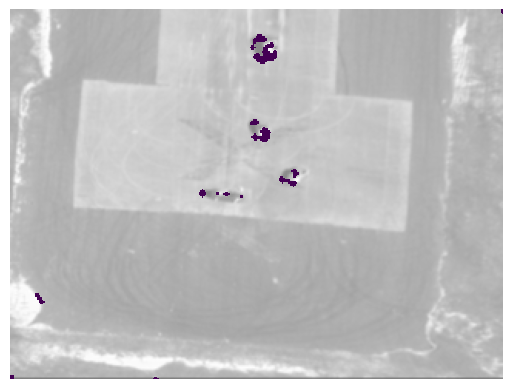

In [12]:
# TODO: visualize
frames_to_save = [30, 60, 90, 120]

for idx in frames_to_save:
    frame = seq[:,:, idx]
    mask = masks[idx-1]
    
    plt.figure()
    plt.imshow(frame, cmap="gray", alpha=0.5)
    plt.imshow(np.ma.masked_where(np.invert(mask), mask))
    plt.axis('off')
    plt.savefig(f"../out/sol_2.3_aerialseq_{idx}.png")
   
    # plt.figure()
    # plt.imshow(frame, cmap="gray", alpha=0.5)
    # plt.imshow(np.ma.masked_where(np.invert(mask), mask))
    # plt.axis('off')
    # plt.savefig(f"../out/sol_2.3_aerialseq_{idx+1}.png")